In [2]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.filters import rank
from scipy import ndimage as ndi
from copy import copy

In [21]:
dome = str(60)


image = sk.io.imread('./../ppujol/cellstosegment/'+dome+'/tp0006-gamma-BAndC.tif')

(606, 690, 574)

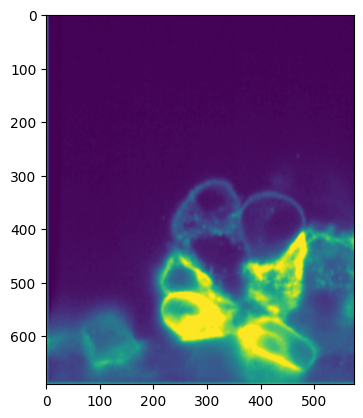

In [22]:
plt.imshow(image[150])
image.shape

In [23]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

(240, 240, 240)

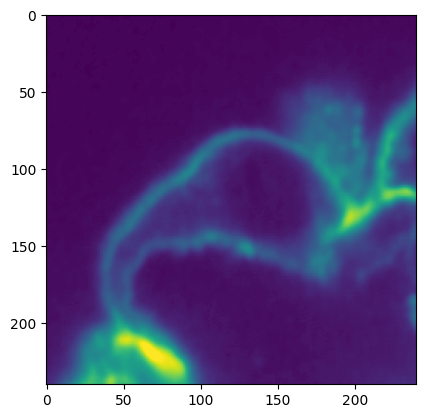

In [24]:
# z, y, x = 183, 300, 300
z, y, x = 183, 337, 300
delta = 120
division = 1
cell = image[z-int(delta/division):z+int(delta/division), y-delta:y+delta, x-delta:x+delta]
cell = normalize_image(cell, 255).astype(np.uint8)
plt.imshow(cell[int(delta/division)])
cell.shape

In [172]:
def watershed_process_membrane_cell__before(cell, plots=False, segmentation=True):

    y = int(delta/division)
    y = 150

    cell = normalize_image(cell, 255).astype(np.uint8)
    cell_border = copy(cell)
    denoised = rank.median(cell_border, ball(2)) # It was 2

    markers = rank.gradient(denoised, ball(5)) < 10
    markers = ndi.label(markers)[0]

    ## Plain shaped
    gradient = rank.gradient(denoised, ball(2))
    # labels = watershed(gradient, markers)

    ## Round shaped
    labels = watershed(denoised, markers)

    all_labels = copy(labels)

    seed_point = (int(delta/division),delta,delta)

    labels[labels != labels[seed_point]] = 0

    labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))



    maskImage = labels*cell_border

    edt = ndi.distance_transform_edt(maskImage)

    # edge_scharr = sk.filters.scharr(cell_border)
    # edge_scharr_cell = edge_scharr*edt


    edt_border_reverse = reverse_values(edt*cell_border) ## Reversed edt*cell
    edt_border = edt*cell_border



    if plots == True:
        plt.figure(figsize=(20,8))
        plt.subplot(251)
        plt.title("Original Image")
        plt.imshow(cell_border[y])
        plt.subplot(252)
        plt.title("Median Filter")
        plt.imshow(denoised[y])
        plt.subplot(253)
        plt.title("Gradient")
        plt.imshow(gradient[y])    
        plt.subplot(254)
        plt.title("Labels")
        plt.imshow(labels[y])
        plt.subplot(255)
        plt.title("labels·cell_border")
        plt.imshow(maskImage[y])
        plt.subplot(256)
        plt.title("Euclidean distance transform")
        plt.imshow(edt[y])
        plt.subplot(257)
        plt.title("Edt border")
        plt.imshow(edt_border[y])
    
    return edt, edt_border, maskImage, labels


KeyboardInterrupt: 

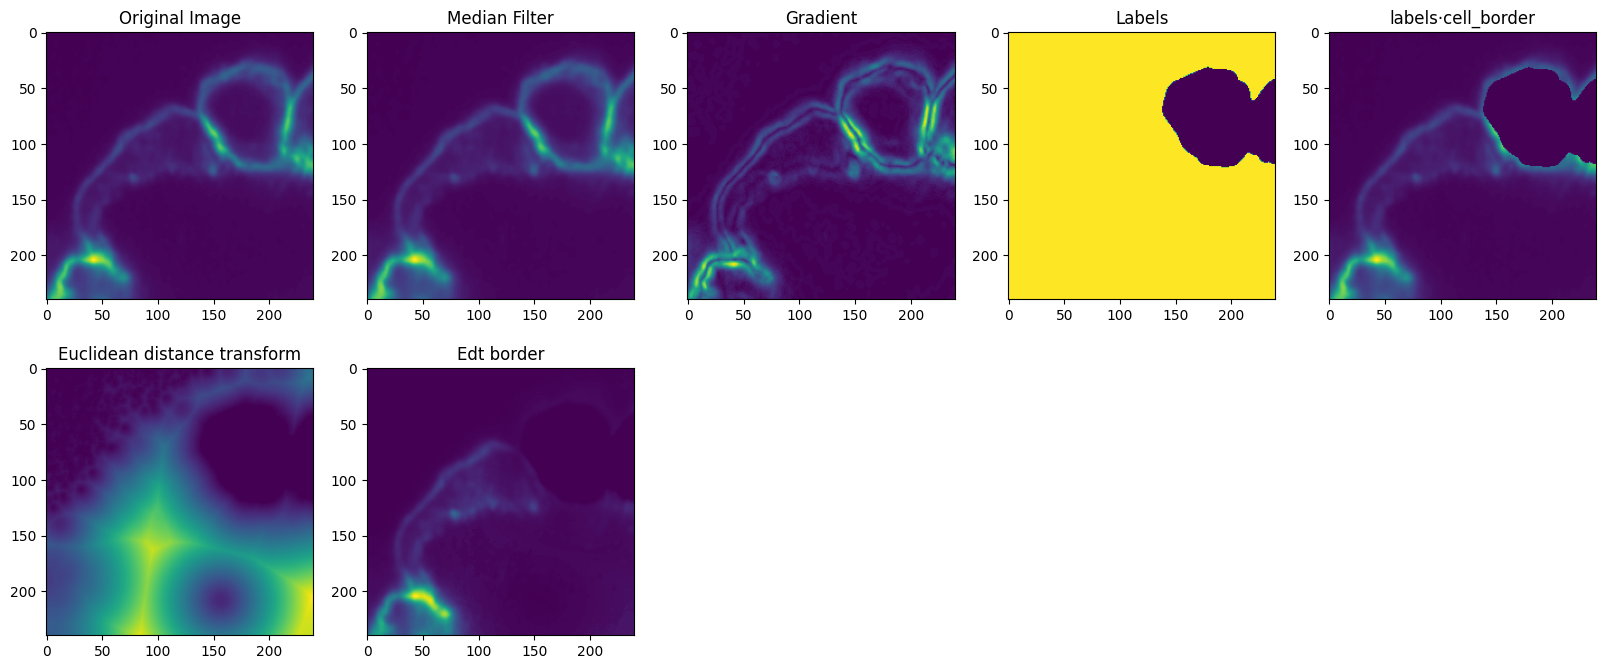

In [12]:
# new_cell = copy(cell)
# all_masks = []
# all_edt = []

# edt, edt_border, maskImage, label  = watershed_process_membrane_cell__before(cell=new_cell, plots=True)
# all_masks.append(maskImage)
# all_edt.append(edt_border)
# for i in range(15):
#     edt_2 = sk.morphology.erosion(edt, footprint=ball(3))
#     edt_2 = normalize_image(edt_2, 255)
#     new_cell = reverse_values(edt_2)*new_cell
#     edt, edt_border, maskImage, _ = watershed_process_membrane_cell__before(cell=new_cell, plots=True)
#     all_masks.append(maskImage)
#     all_edt.append(edt_border)
#     print(i)

In [177]:
def watershed_process_membrane_cell(cell, plots=False, gradient_in_labels=False, prev_mask=0):

    y = int(delta/division)
    # y = 150

    cell = normalize_image(cell, 255).astype(np.uint8)
    cell_border = copy(cell)
    denoised = rank.median(cell_border, ball(2)) # It was 2

    markers = rank.gradient(denoised, ball(5)) < 10
    markers = ndi.label(markers)[0]

    gradient = rank.gradient(denoised, ball(2))
    gradient = gradient-prev_mask
    labels = watershed(denoised, markers) if gradient_in_labels == False else watershed(gradient, markers)

    all_labels = copy(labels)

    seed_point = (int(delta/division),delta,delta)

    labels[labels != labels[seed_point]] = 0

    labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))

    maskImage = labels*cell_border

    edt = ndi.distance_transform_edt(maskImage)
    

    edt_border_reverse = reverse_values(edt*cell_border) ## Reversed edt*cell
    edt_border = edt*cell_border



    if plots == True:
        plt.figure(figsize=(20,8))
        plt.subplot(251)
        plt.title("Original Image")
        plt.imshow(cell_border[y])
        plt.subplot(252)
        plt.title("Median Filter")
        plt.imshow(denoised[y])
        plt.subplot(253)
        plt.title("Gradient")
        plt.imshow(gradient[y])    
        plt.subplot(254)
        plt.title("Labels")
        plt.imshow(labels[y])
        plt.subplot(255)
        plt.title("labels·cell_border")
        plt.imshow(maskImage[y])
        plt.subplot(256)
        plt.title("Euclidean distance transform")
        plt.imshow(edt[y])
        plt.subplot(257)
        plt.title("Edt border")
        plt.imshow(edt_border[y])
    
    return edt, edt_border, maskImage, labels, all_labels


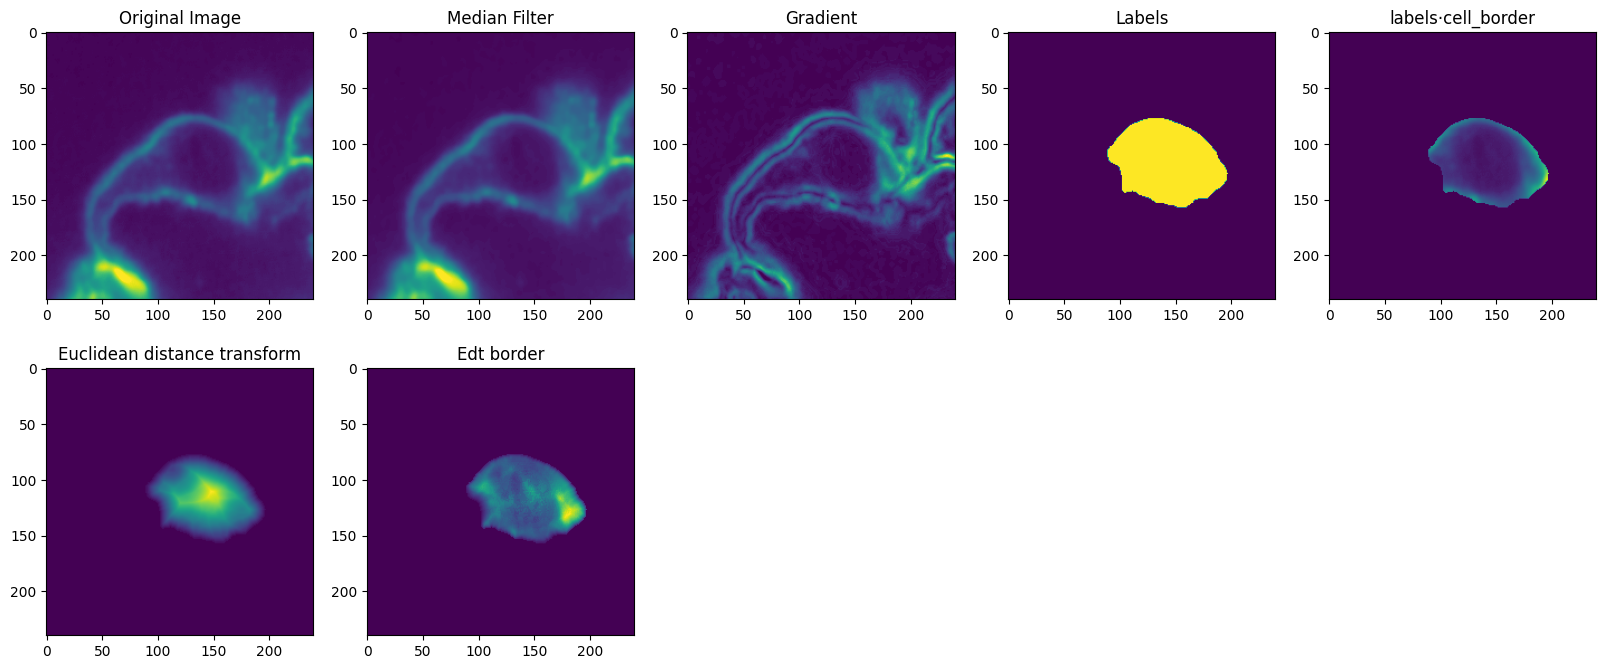

In [178]:
edt, edt_border, maskImage, label, all_labels = watershed_process_membrane_cell(cell=cell, plots=True, gradient_in_labels=False)

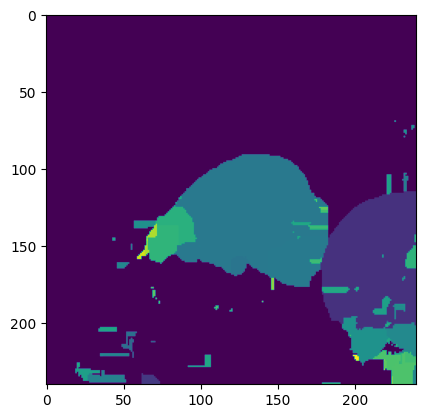

In [179]:
plt.imshow(all_labels[95])

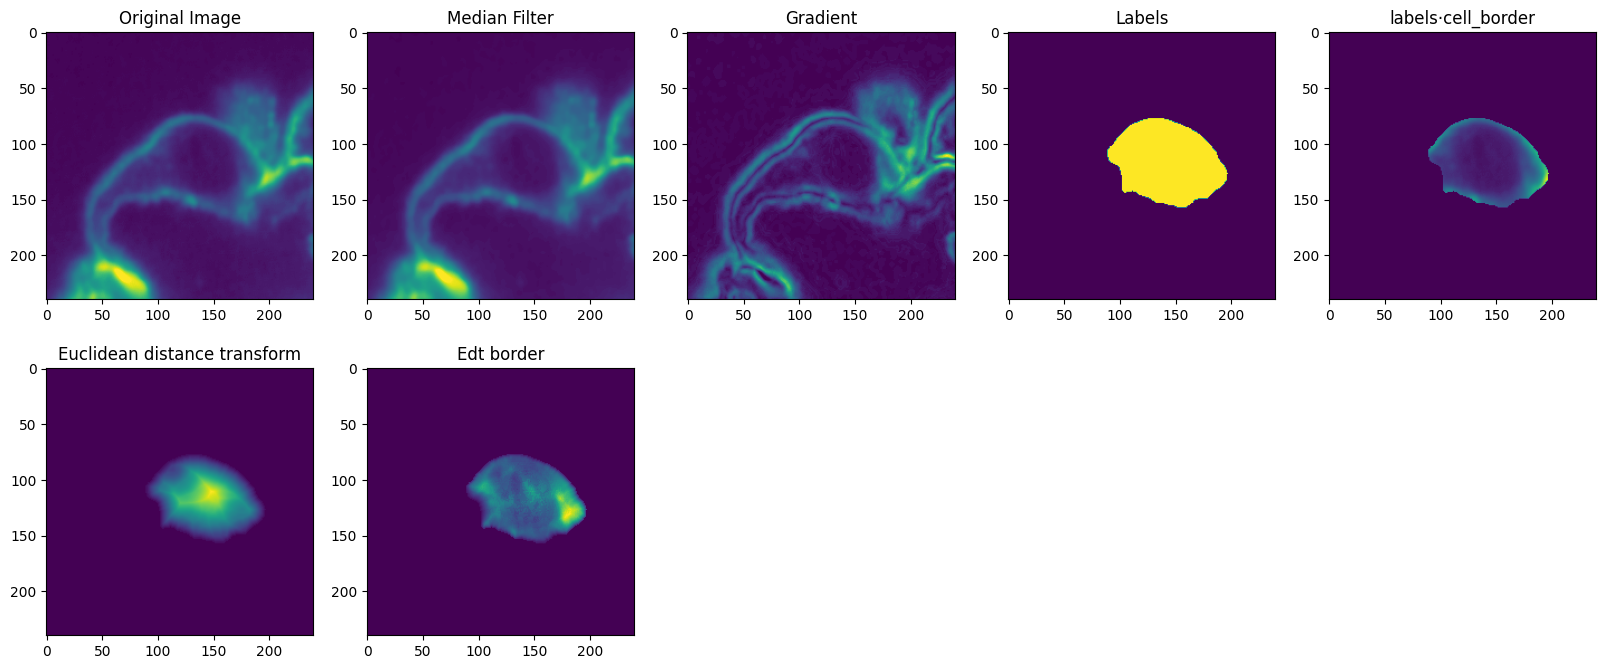

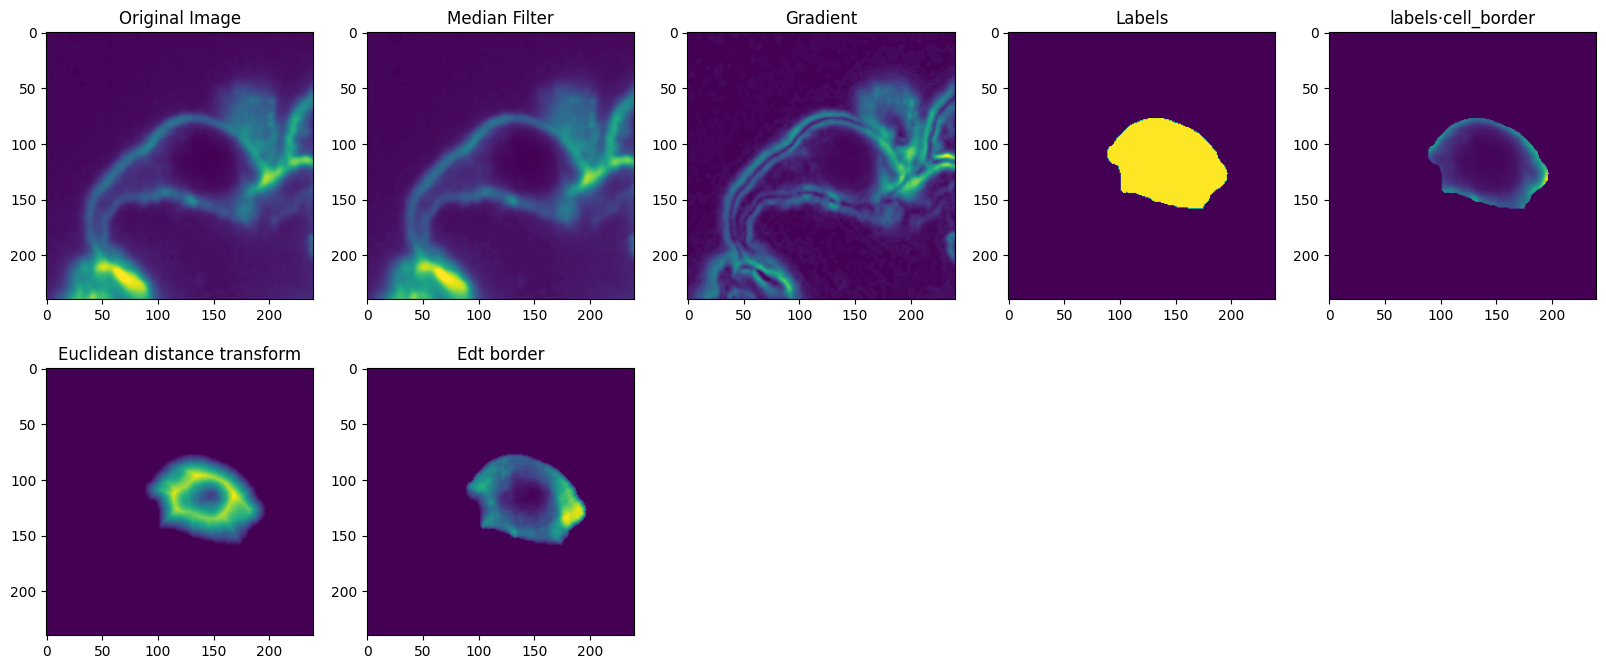

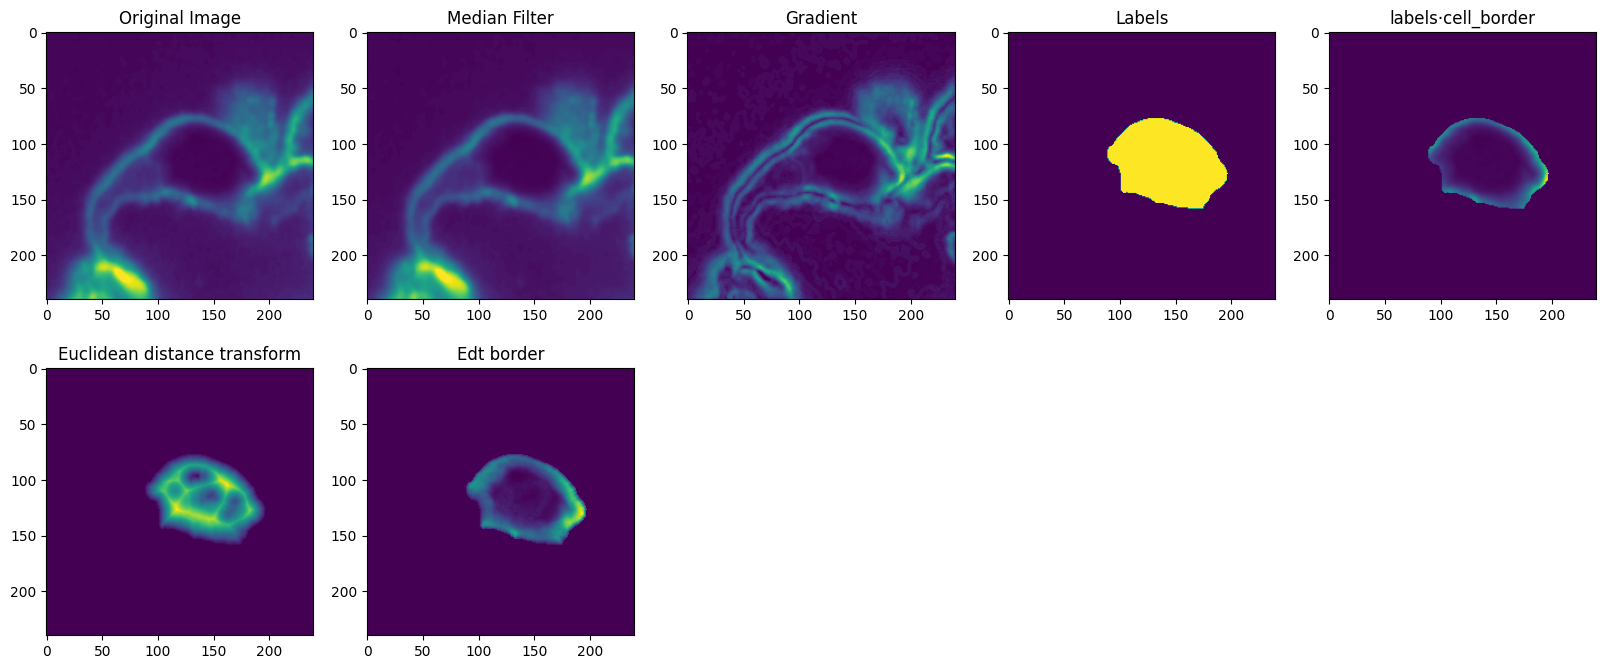

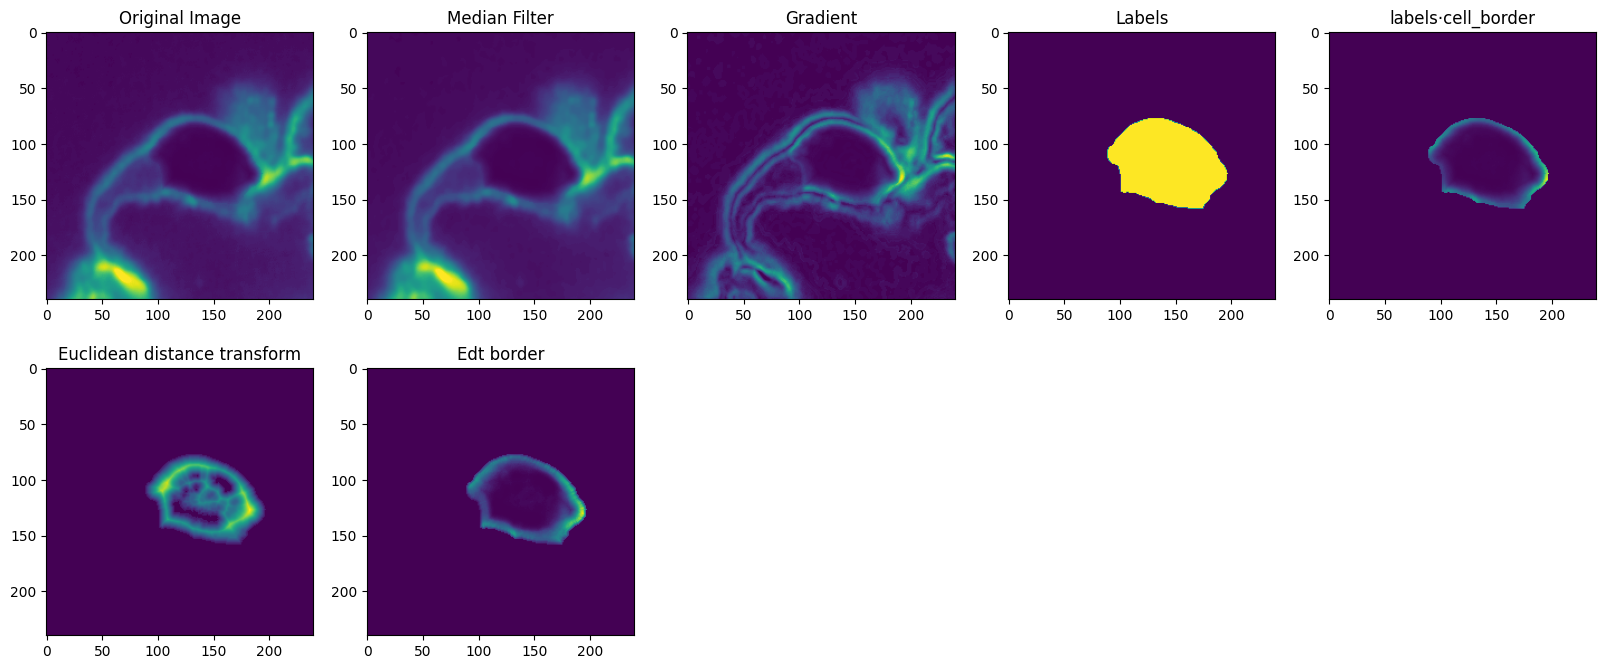

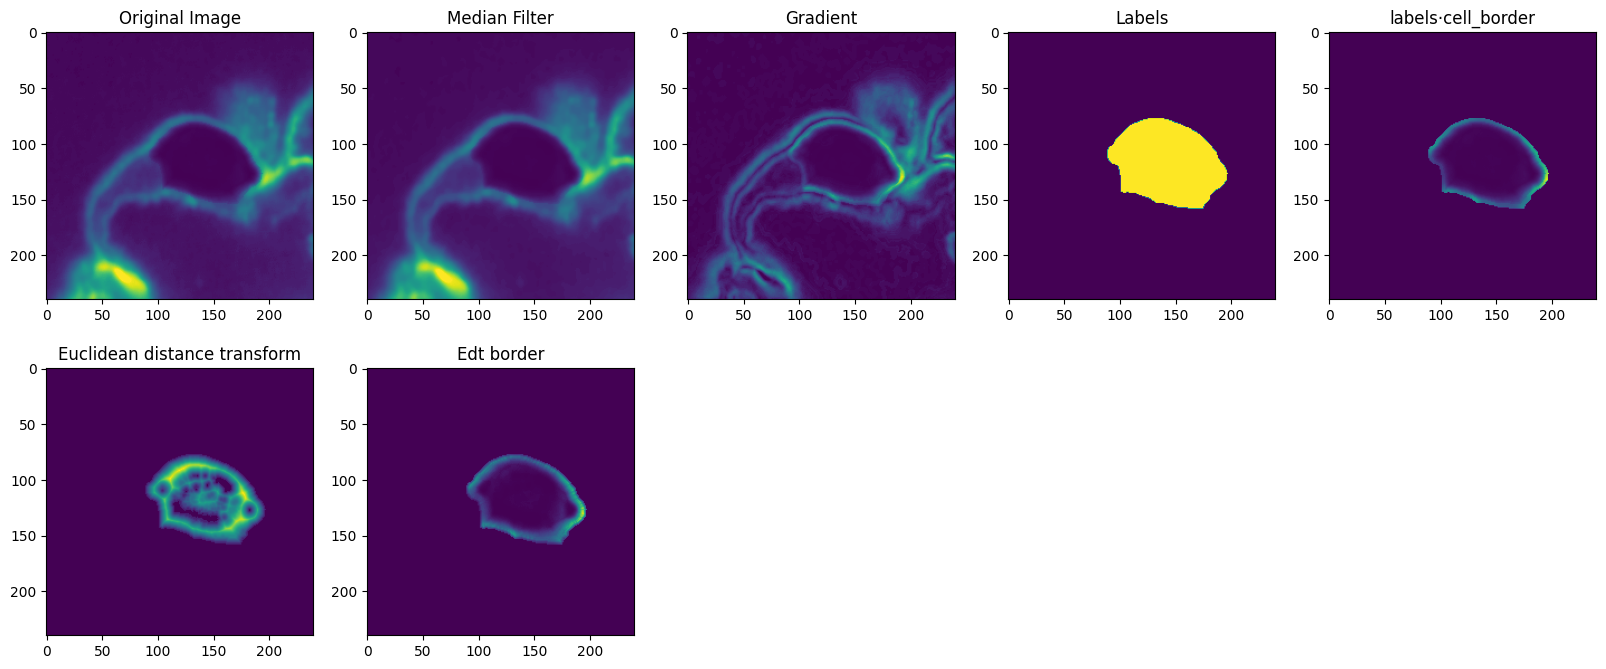

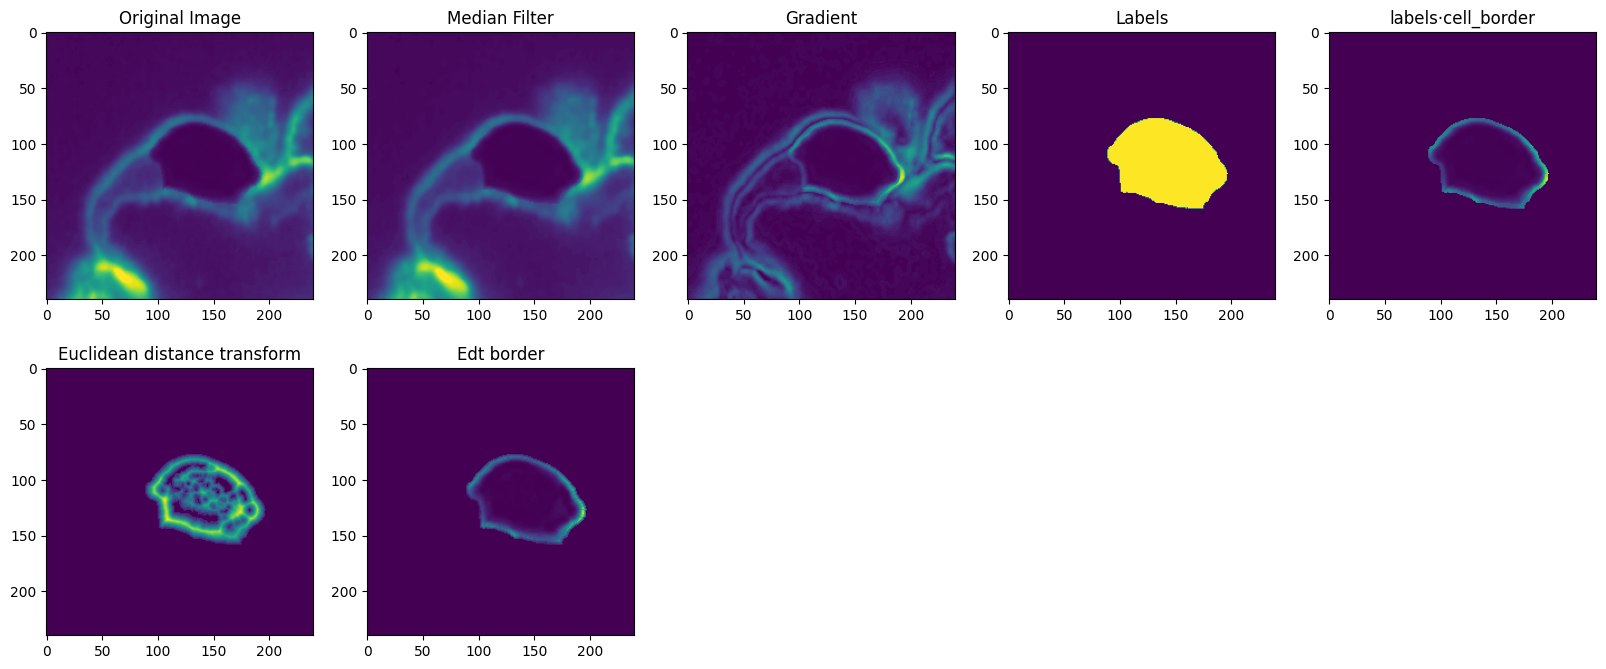

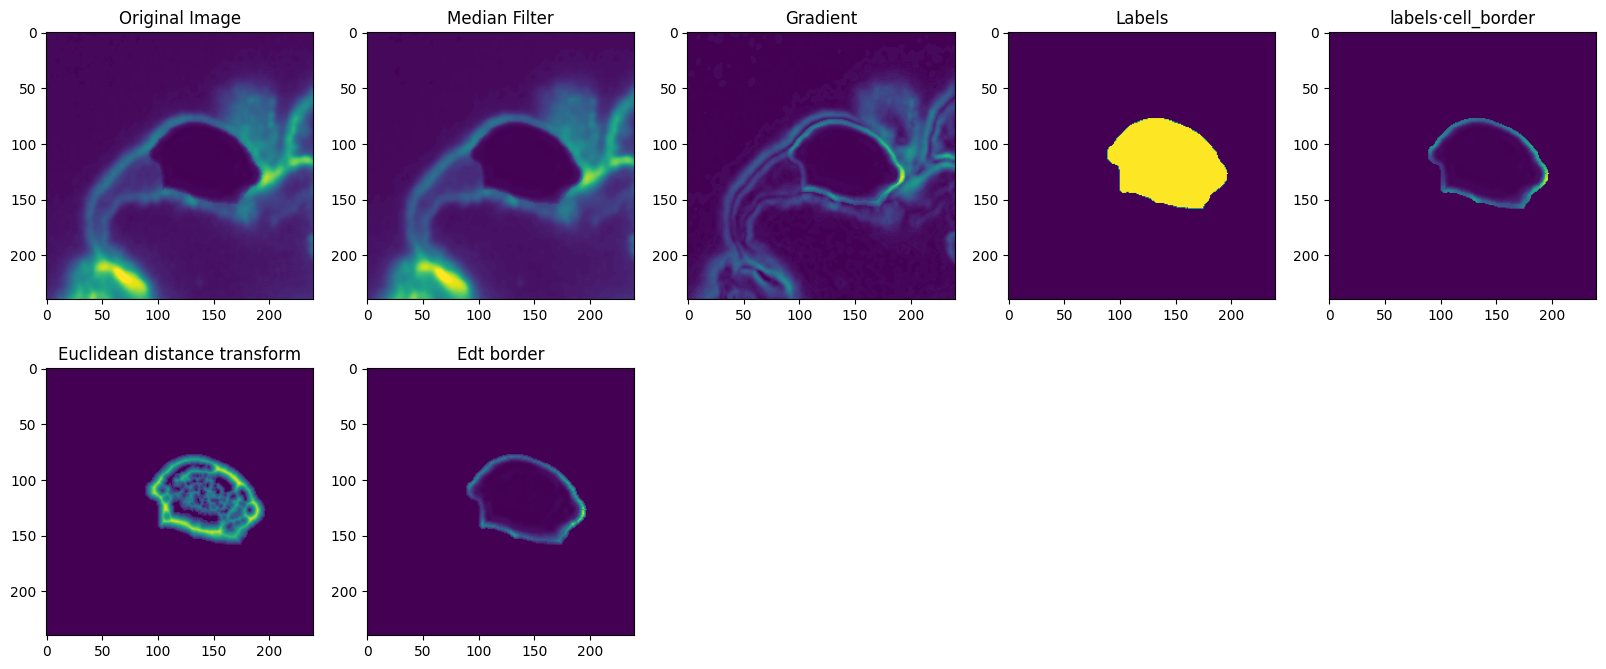

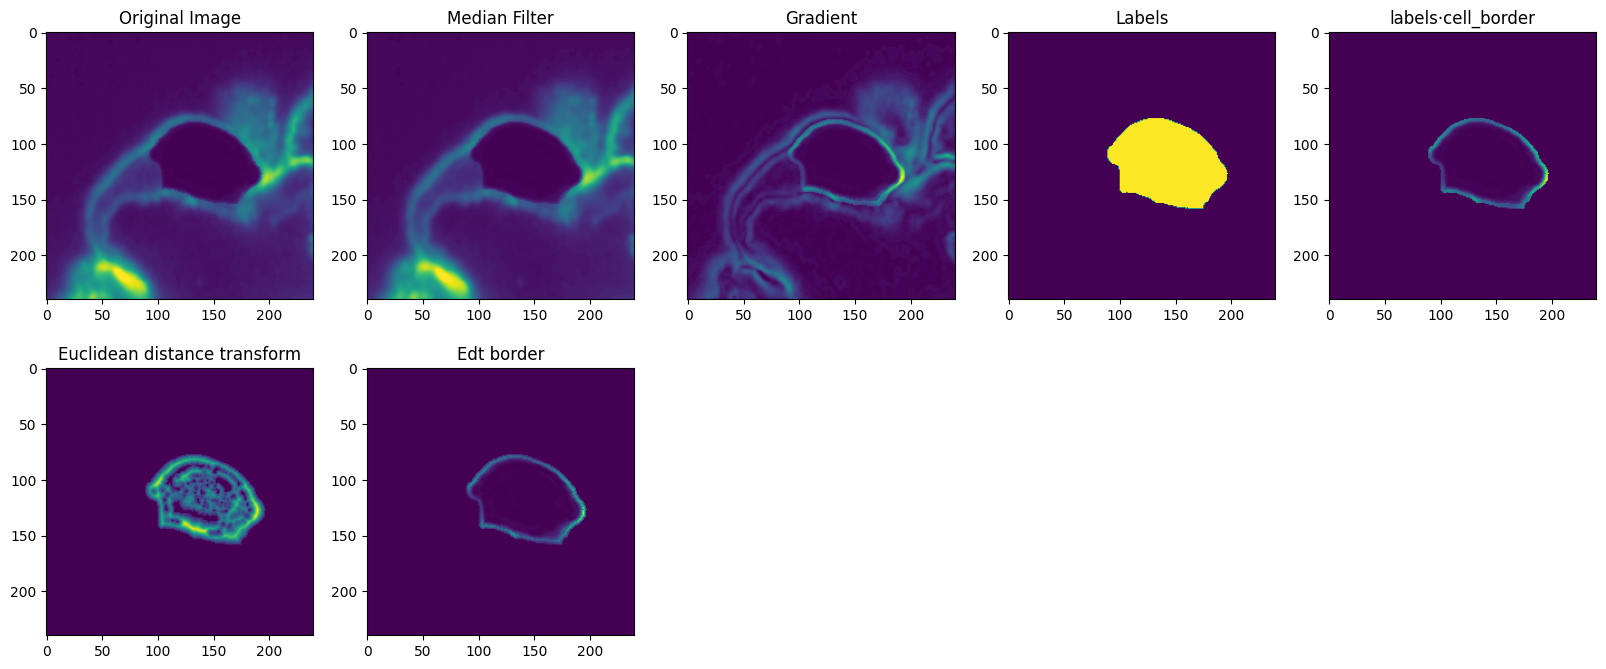

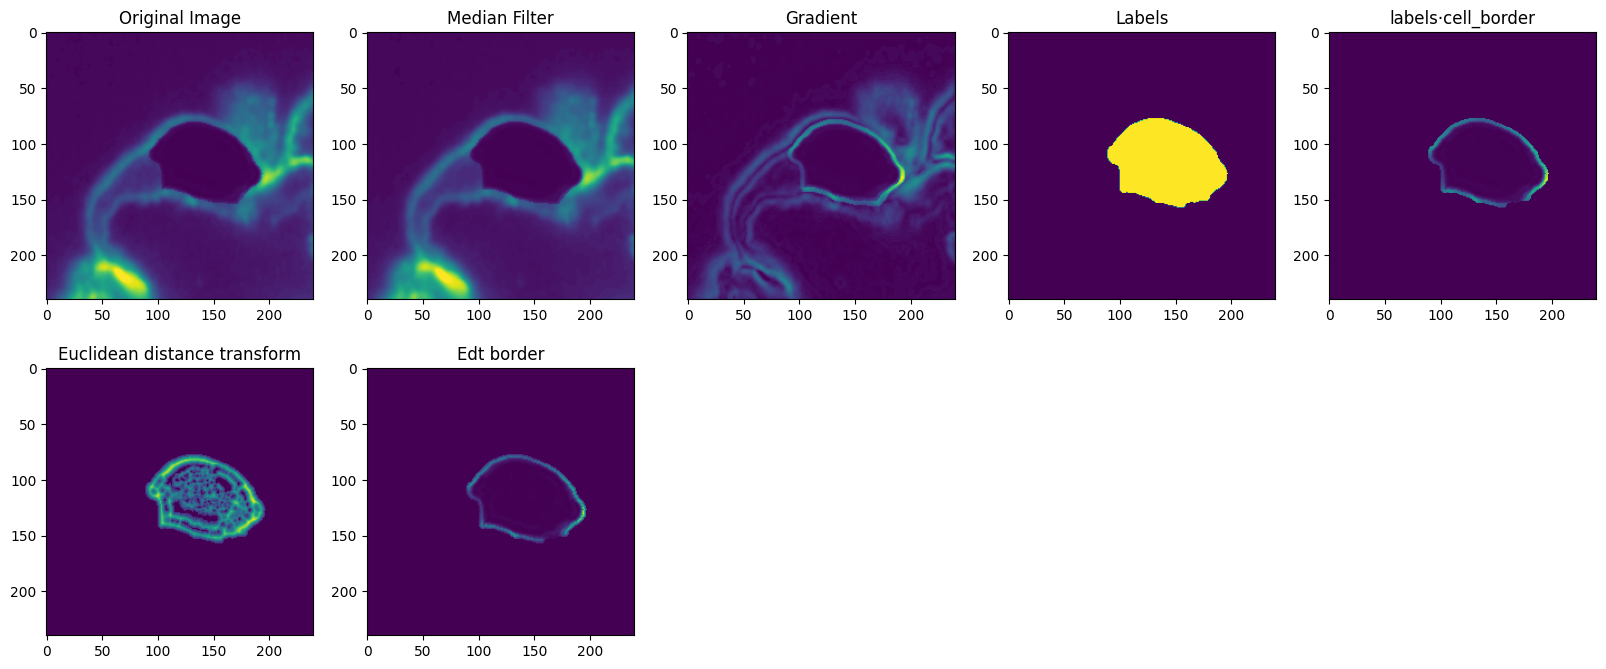

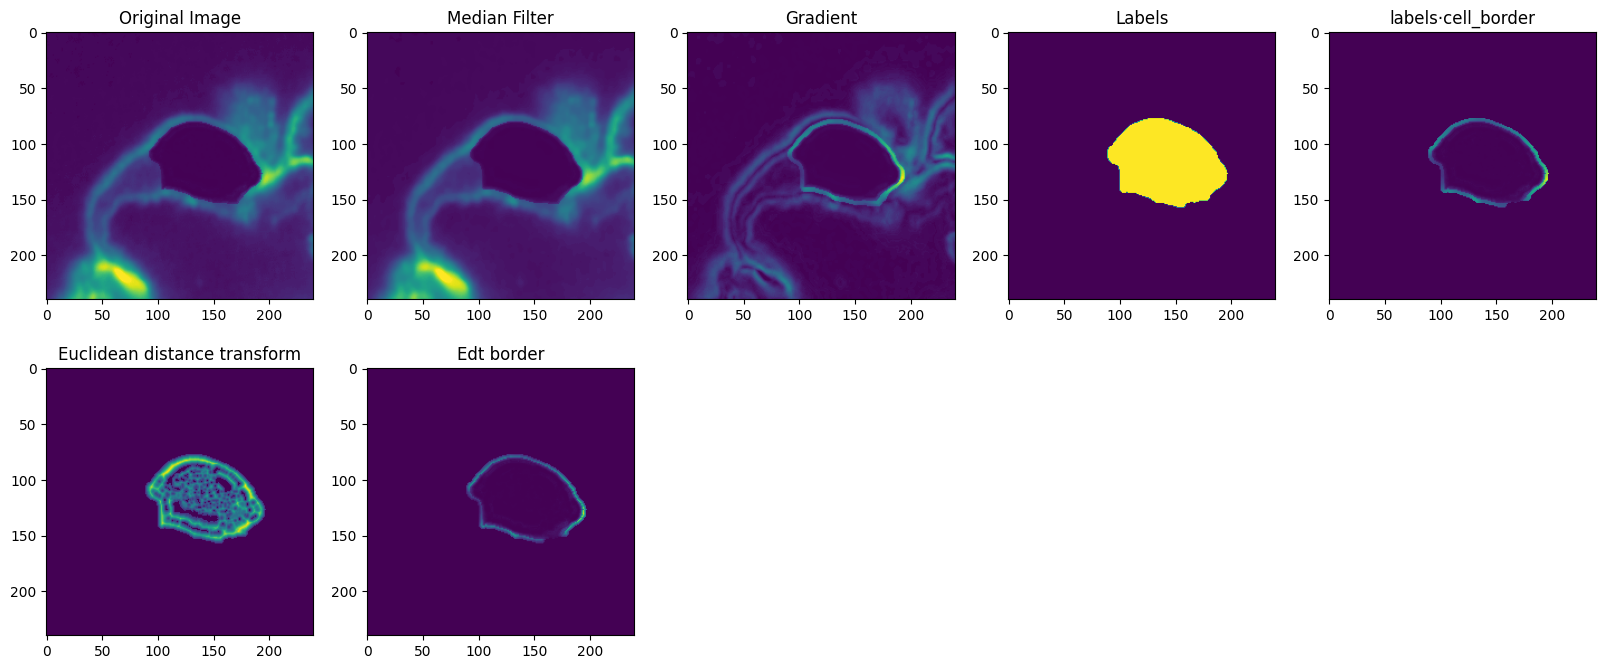

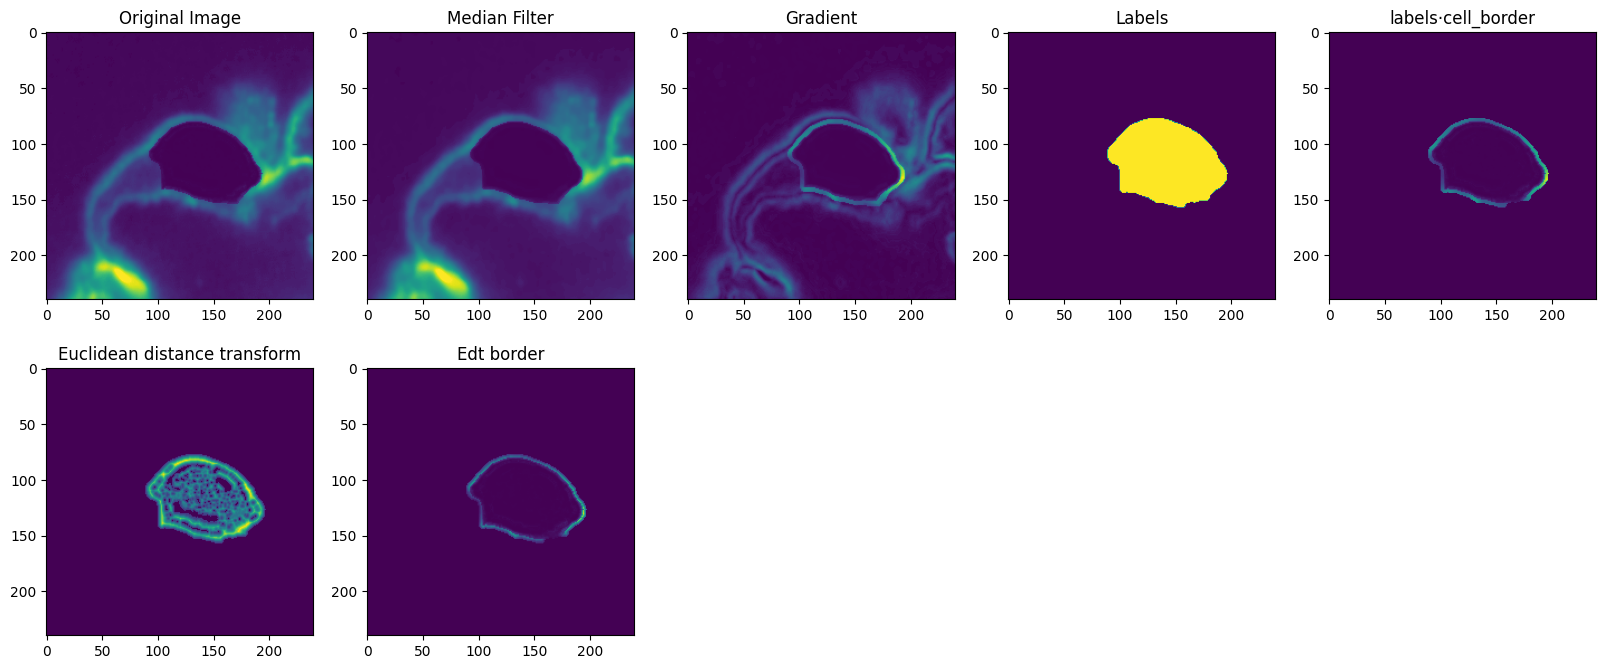

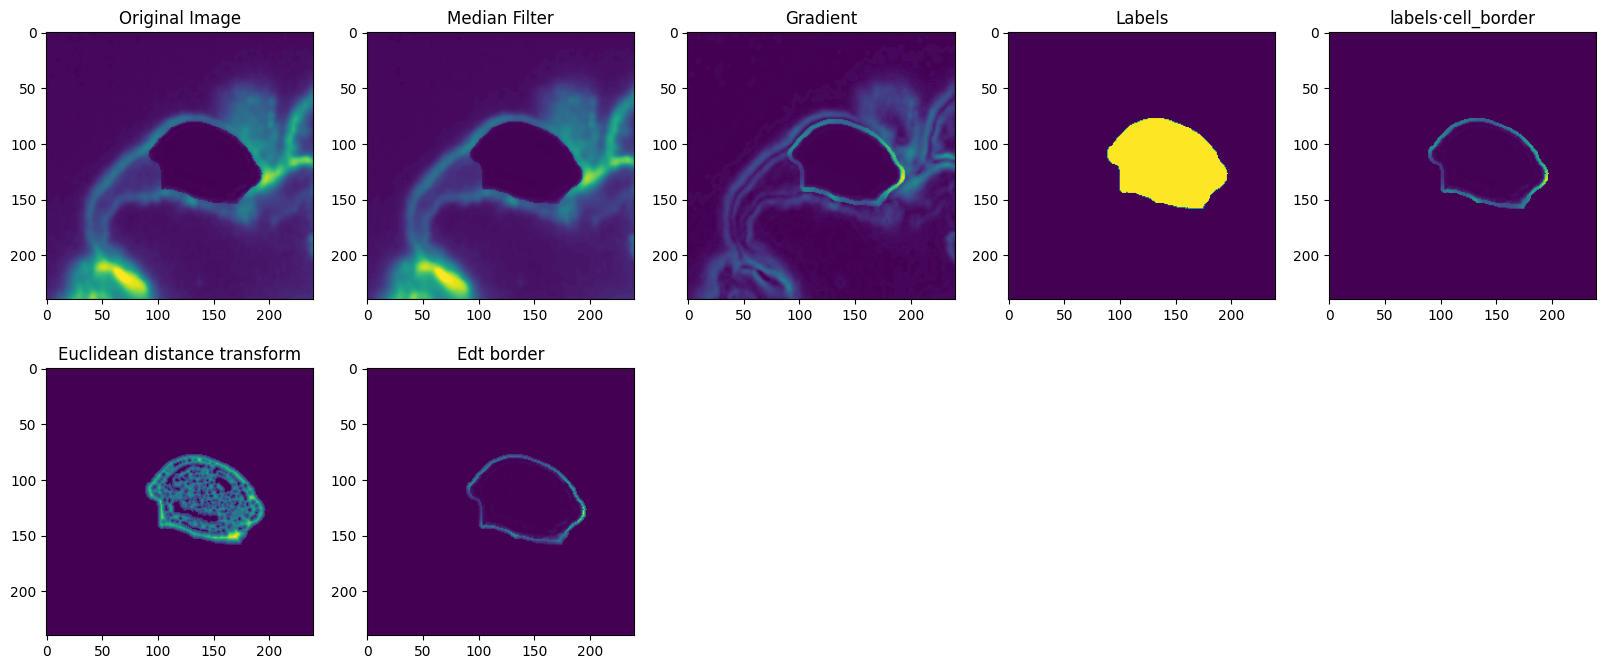

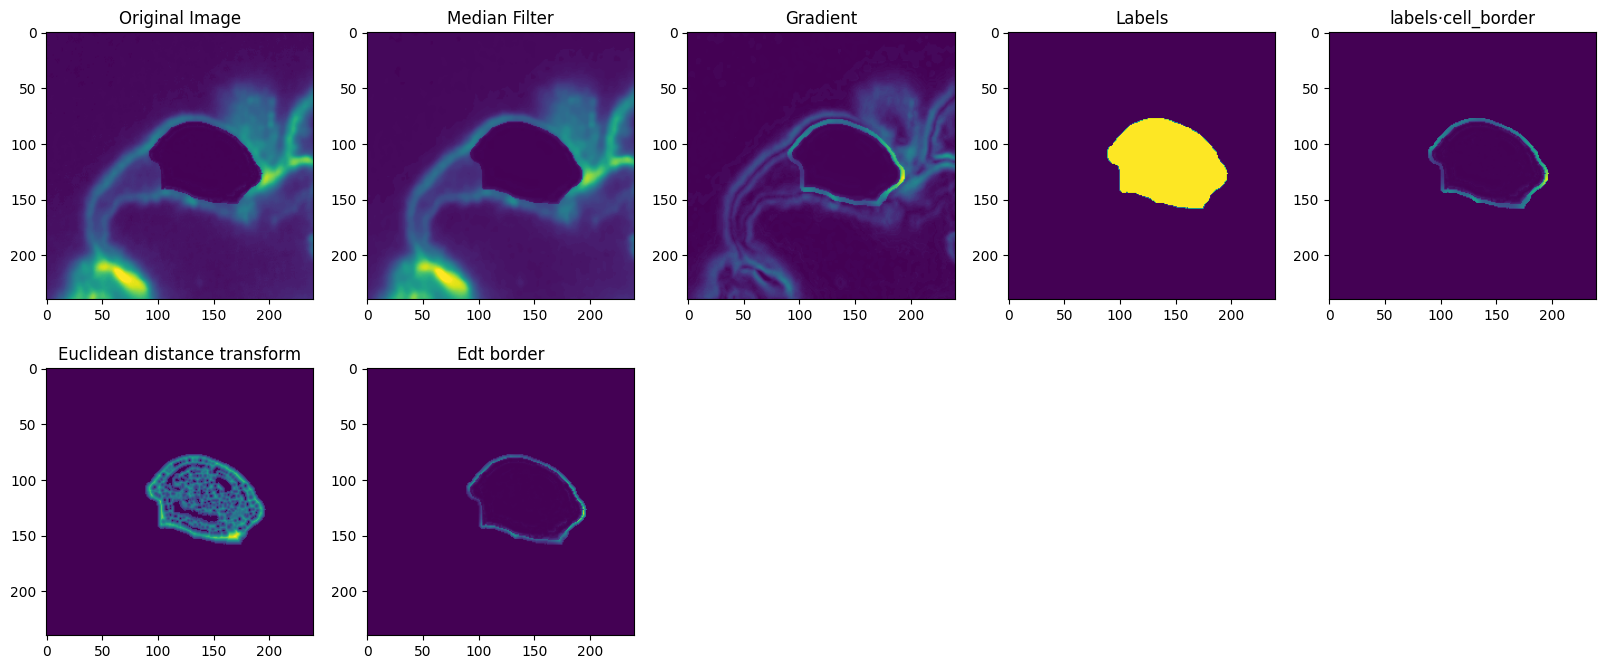

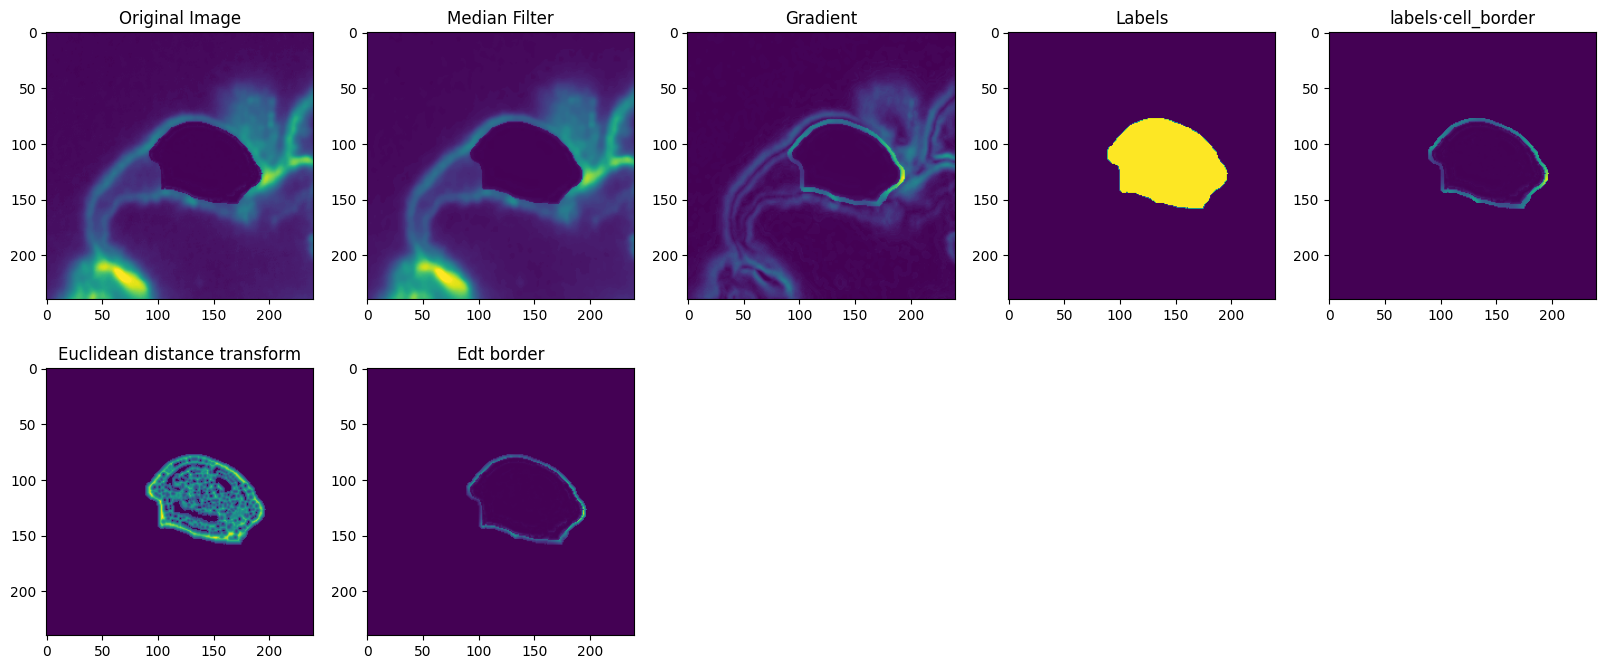

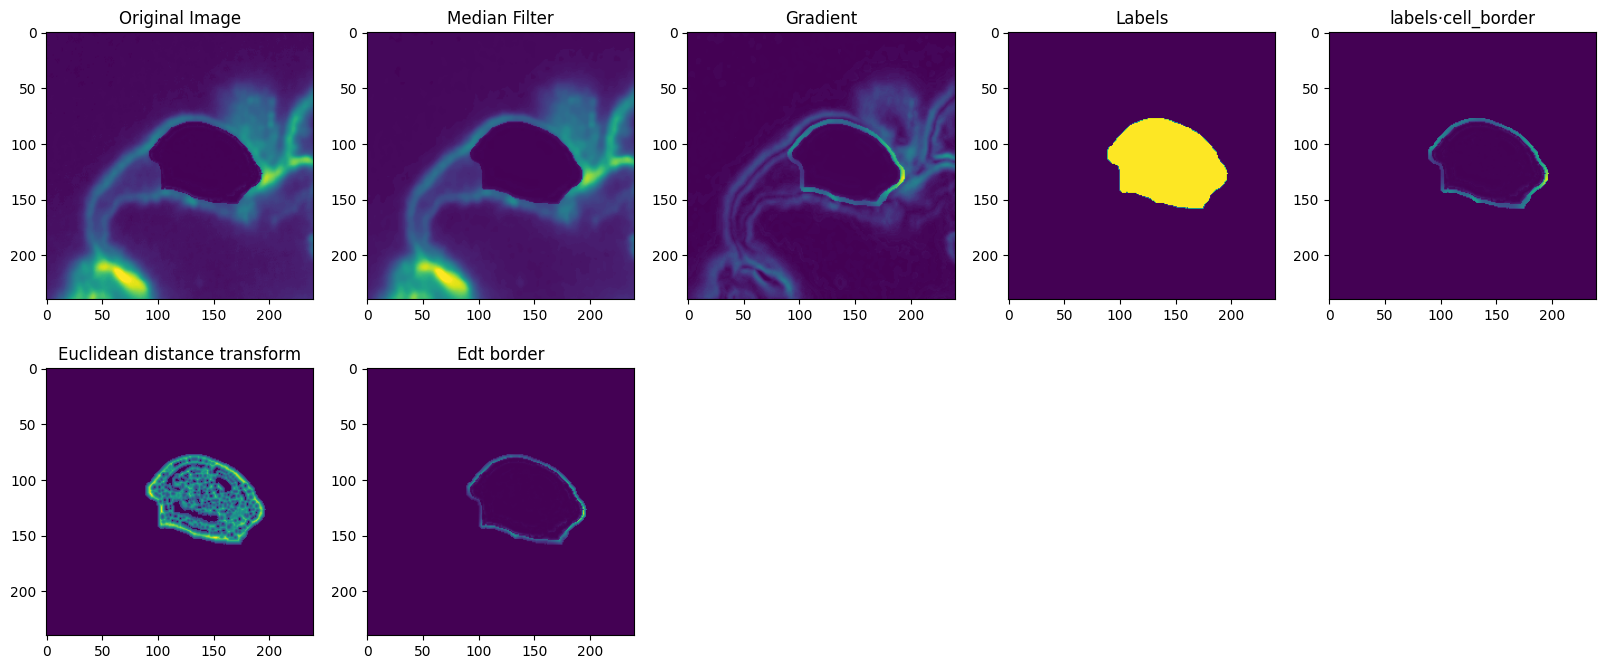

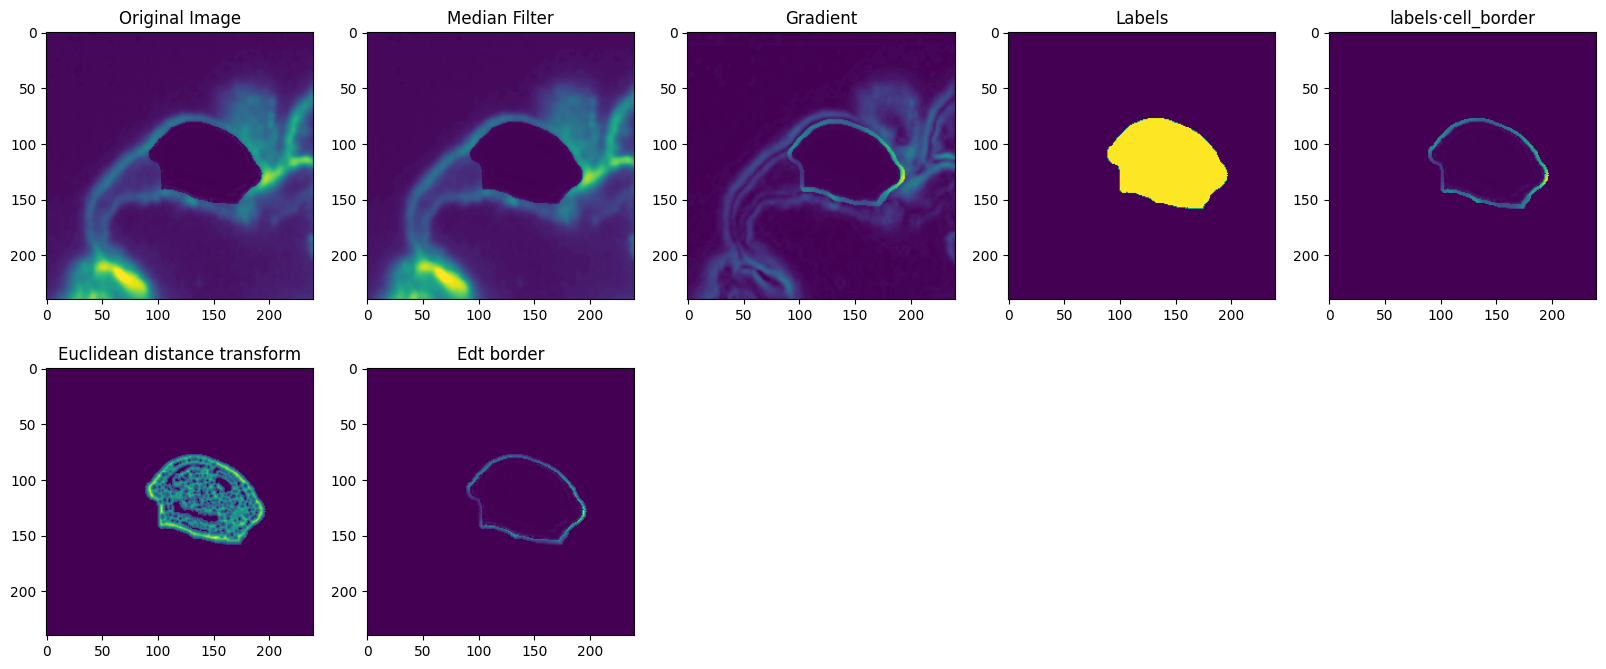

In [27]:
new_cell = copy(cell)
all_masks = []
all_edt = []
all_all_labels = []
edt, edt_border, maskImage, label, all_labels  = watershed_process_membrane_cell(cell=new_cell, plots=True)
all_masks.append(label)
all_edt.append(edt_border)
all_all_labels.append(all_labels)
for i in range(15):
    edt_2 = sk.morphology.erosion(edt, footprint=ball(3))
    # edt_2 = normalize_image(edt_2, 255)
    new_cell = reverse_values(edt_2)*new_cell
    edt, edt_border, maskImage, label, all_labels = watershed_process_membrane_cell(cell=new_cell, plots=True)
    all_masks.append(label)
    all_edt.append(edt_border)
    all_all_labels.append(all_labels)
    print(i, end='\r')

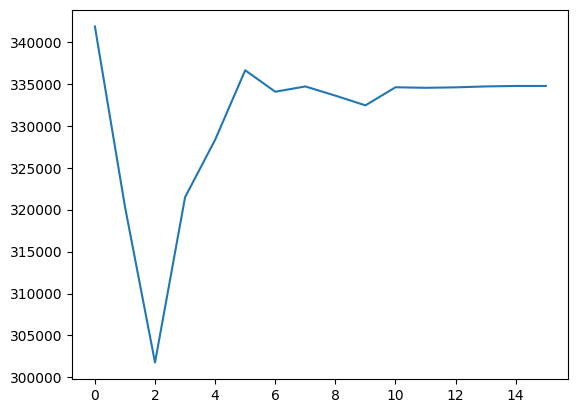

In [218]:
vols = []
for i in all_masks:
    vols.append(np.count_nonzero(i))

plt.plot(vols)

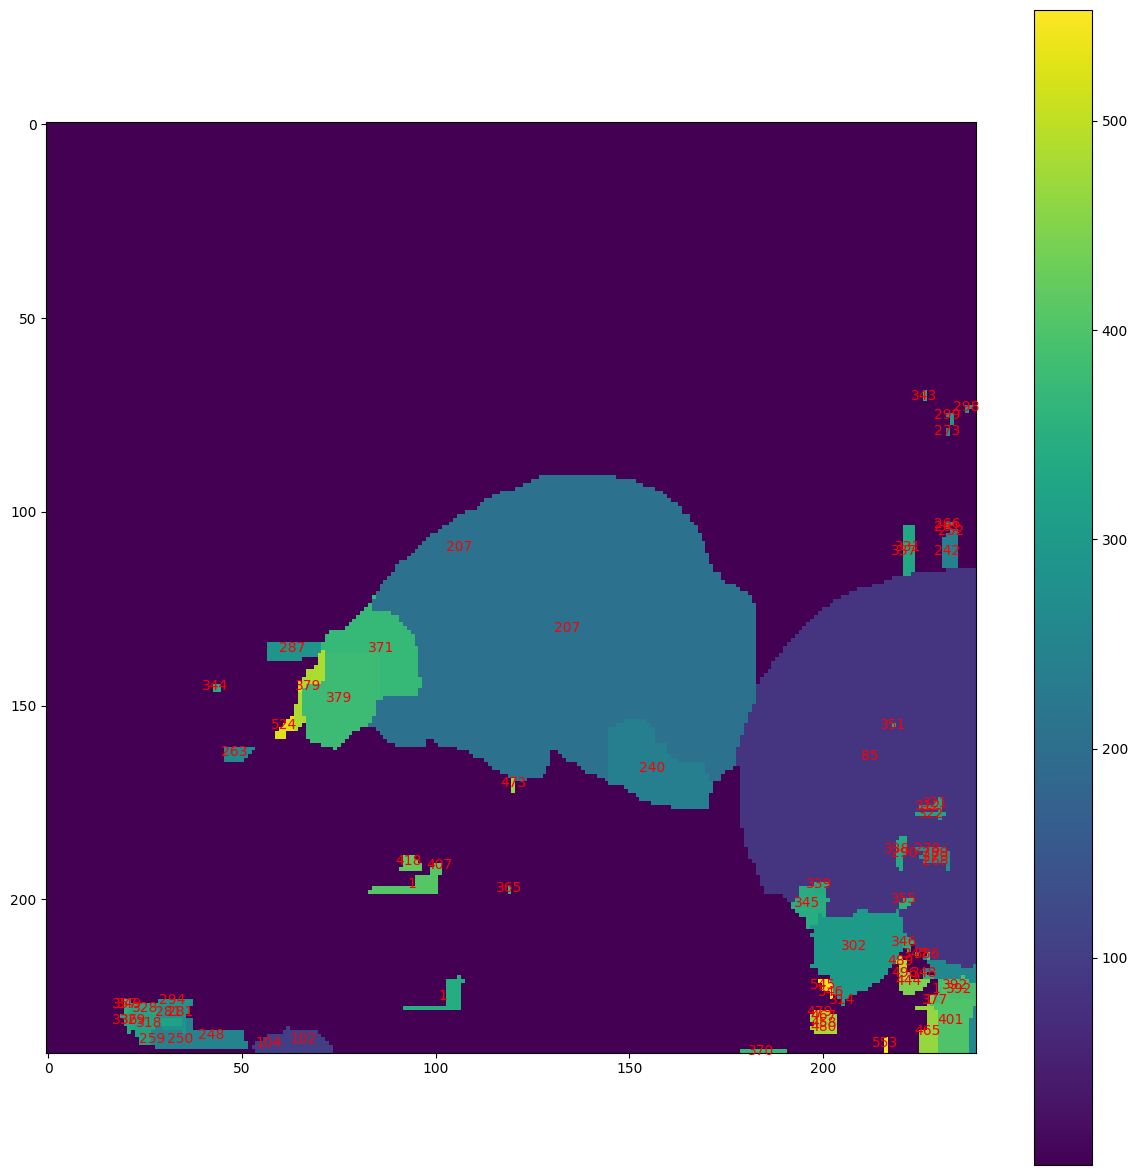

In [168]:
# plt.imshow(all_masks[4][150])
# plt.imshow(cell[150], alpha=0.9)

from scipy import  ndimage

plt.figure(figsize=(15,15))
masked_image = all_all_labels[9][95]
plt.imshow(masked_image)
plt.colorbar()




intensities = {}
unique_masks = np.unique(masked_image)
for mask in unique_masks:
    temp_mask = copy(masked_image)
    temp_mask[temp_mask != mask] = 0
    plt.imshow(temp_mask)
    center = ndimage.center_of_mass(temp_mask)
    intensities[mask] = center
        

intensities = {k: (int(v[0]), int(v[1])) for k, v in intensities.items() if not any(np.isnan(coord) for coord in v)}

plt.imshow(masked_image)

# Display the intensity value at the center of mass for each label
for center in intensities:
    center = intensities[center]
    plt.text(center[1], center[0], f'{masked_image[int(center[0]), int(center[1])]}',  
             ha='center', va='center', color='red')




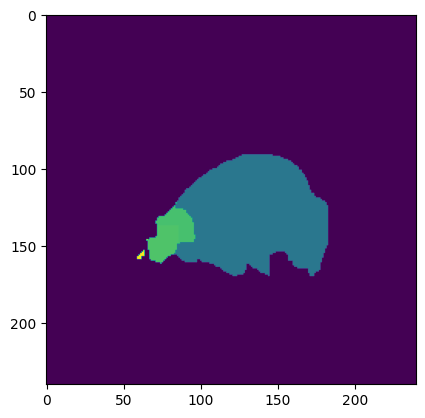

In [170]:
# temp_mask = copy(masked_image)
# temp_mask[temp_mask != 723] = 0
d3_masked_image = copy(all_all_labels[9])
mask_numbers = [207, 371, 524, 723, 707, 752, 550, 505, 925, 938, 926, 1147, 965, 880, 371, 1147, 880, 794, 976, 986, 811, 735, 976, 906, 379, 524]
mask_complete = np.isin(d3_masked_image, mask_numbers)
d3_masked_image[~mask_complete] =  0

plt.imshow(d3_masked_image[95])

In [166]:
import tifffile as tiff
tiff.imwrite('./../ppujol/cellstosegment/'+dome+'/temp_many.tif', d3_masked_image.astype(np.uint16), imagej=True)

image_write = './../ppujol/cellstosegment/'+dome+'/image_cell.tif'
tiff.imwrite(image_write, normalize_image(cell, 65535).astype(np.uint16), imagej=True)

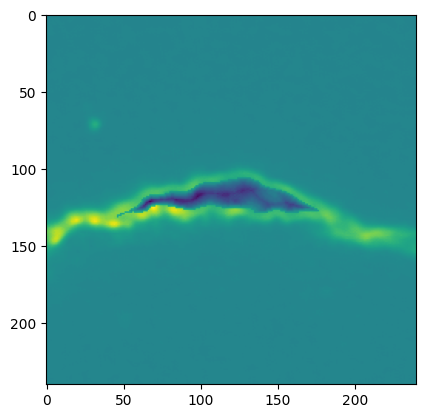

In [222]:
mask = all_masks[4]
mask = mask*cell

edt_mask = sk.morphology.erosion(ndi.distance_transform_edt(mask), footprint=ball(2))
edt_mask = normalize_image(edt_mask, 255)

void = edt_mask*cell
void = normalize_image(void, 255)
void = cell-void

plt.imshow(void[150])

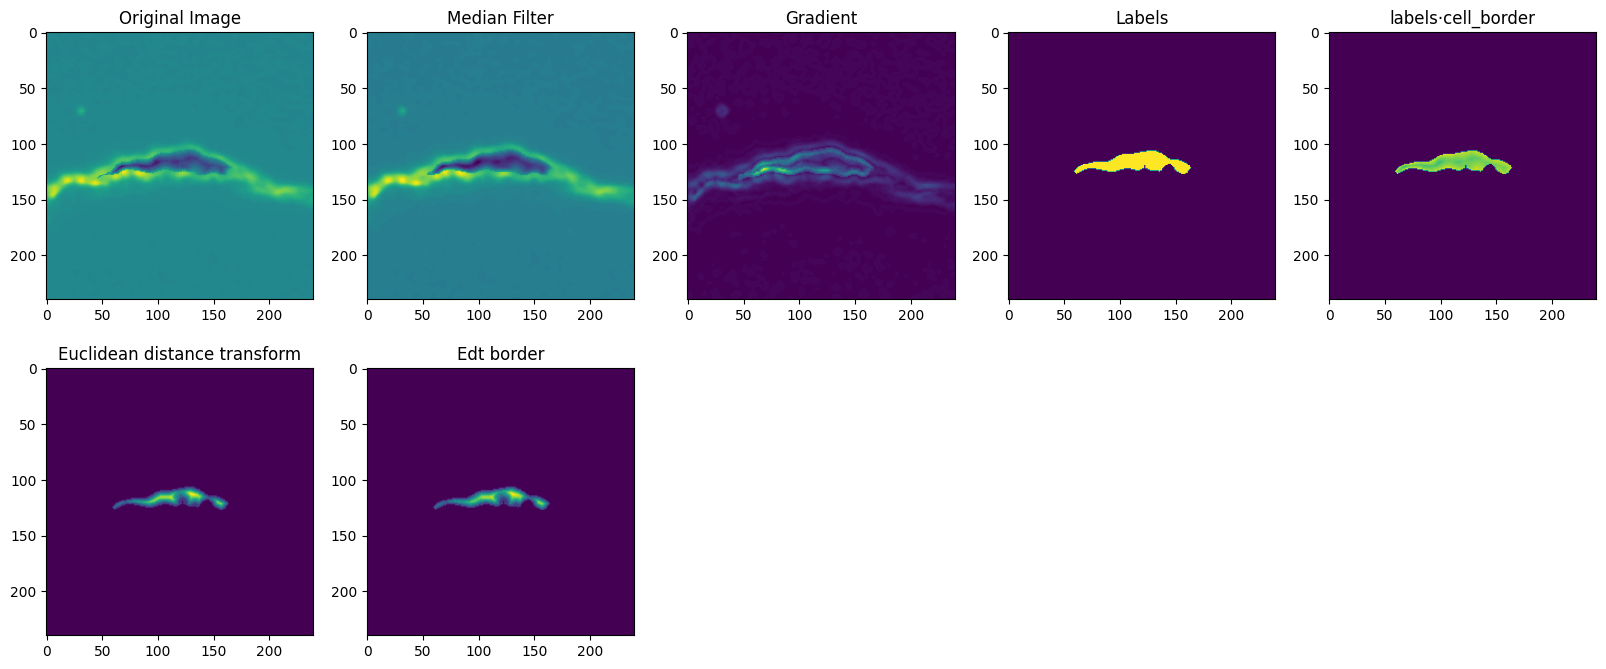

In [213]:
edt_temp, edt_border_temp, maskImage_temp, label_temp, _ = watershed_process_membrane_cell(cell=void, plots=True, gradient_in_labels=True, prev_mask=0)

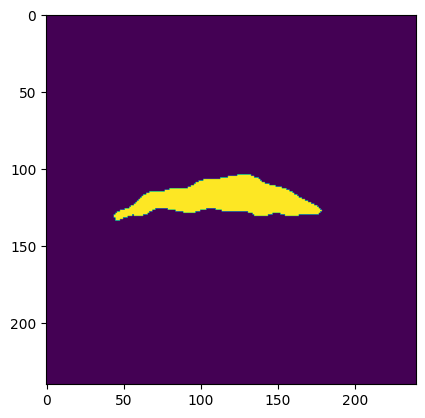

In [223]:
plt.imshow(all_masks[4][150])

In [233]:
import tifffile as tiff
cell_write = './../ppujol/cellstosegment/'+str(56)+'/cell_4.tif'
image_write = './../ppujol/cellstosegment/'+str(56)+'/image_4.tif'
all_labels_write = './../ppujol/cellstosegment/'+str(56)+'/all_labels_4.tif'

# tiff.imwrite(cell_write, normalize_image(reverse_values(edt_border_inside_2), 65535).astype(np.uint16), imagej=True)
tiff.imwrite(cell_write, all_masks[4].astype(np.uint16), imagej=True)
tiff.imwrite(all_labels_write, normalize_image(all_all_labels[4], all_all_labels[4].max()).astype(np.uint16), imagej=True)
tiff.imwrite(image_write, normalize_image(cell, 65535).astype(np.uint16), imagej=True)